In [107]:
import pandas as pd
from matplotlib import pyplot as plt

In [116]:
# Load a file under "data" folder
file = "./data/sense.csv"
data = pd.read_csv(file, sep=",", encoding="euc-kr")

data['Sensor time'] = data['Sensor time'].astype(str)
data["Sensor time"]= data["Sensor time"].str[:12]
data['Sensor time'] = pd.to_datetime(data['Sensor time'], format="%Y%m%d%H%M")

data.drop('Time', axis = 1, inplace = True)
data.drop('Barn number', axis = 1, inplace = True)
data.drop('Module ID', axis = 1, inplace = True)

In [117]:
pivoted = data.pivot(['Sensor time','Collecting device ID'], 'Type', 'Vlaue')
#pivoted = data.pivot('Sensor time', 'Type', 'Vlaue')
pivoted = pivoted.reset_index()
pivoted_sorted = pivoted.sort_values(by='Sensor time' ,ascending=True)

In [127]:
filtered_df=pivoted_sorted[(pivoted_sorted['Sensor time'] >= '2021-06-20')]
filtered_df

Type,Sensor time,Collecting device ID,co2,humidity,nh3,temp
4291,2021-06-20 00:00:00,GW01,420.46,NaN,23.81,NaN
4292,2021-06-20 00:02:00,GW01,420.73,NaN,24.07,NaN
4293,2021-06-20 00:04:00,GW01,421.10,NaN,24.45,NaN
4294,2021-06-20 00:06:00,GW01,421.30,NaN,24.64,NaN
4295,2021-06-20 00:08:00,GW01,421.63,NaN,24.98,NaN
...,...,...,...,...,...,...
13001,2021-06-30 23:50:00,GW01,402.92,99.89994,4.42,21.10499
13002,2021-06-30 23:52:00,GW01,402.91,99.89994,4.41,21.11694
13003,2021-06-30 23:54:00,GW01,402.92,99.89994,4.42,21.10168
13004,2021-06-30 23:56:00,GW01,402.89,99.89994,4.39,21.10338


In [128]:
grouped_df_mean = filtered_df.groupby(pd.Grouper(key='Sensor time' ,freq='1h')).mean()
grouped_df_mean = grouped_df_mean.dropna()

In [129]:
grouped_df_mean

Type,co2,humidity,nh3,temp
Sensor time,,,,
2021-06-22 12:00:00,403.708571,58.841321,5.165000,28.488098
2021-06-22 13:00:00,401.477000,53.719699,2.450333,29.090751
2021-06-22 14:00:00,401.409333,48.793622,2.356667,29.843395
2021-06-22 15:00:00,401.658000,47.732757,2.707333,30.333684
2021-06-22 16:00:00,400.218333,41.840305,0.455000,29.130241
...,...,...,...,...
2021-06-30 19:00:00,402.696667,99.781939,4.131667,24.828546
2021-06-30 20:00:00,402.187333,99.899941,3.445667,23.243017
2021-06-30 21:00:00,402.005333,99.899941,3.198000,22.113639


In [130]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

In [131]:
%matplotlib inline

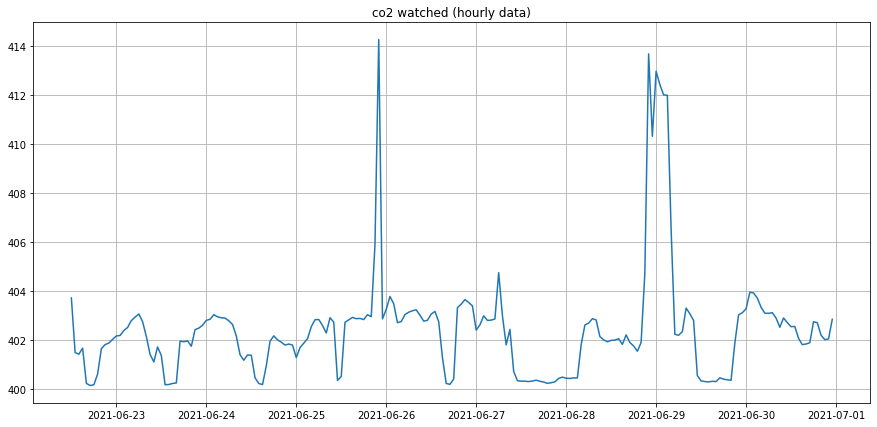

In [132]:
plt.figure(figsize=(15, 7))
plt.plot(grouped_df_mean['co2'])
plt.title('co2 watched (hourly data)')
plt.grid(True)
plt.show()

In [133]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [134]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [135]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

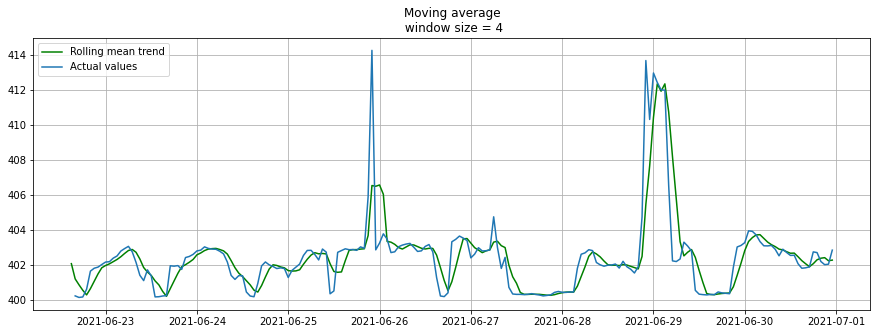

In [136]:
plotMovingAverage(grouped_df_mean['co2'], 4) 

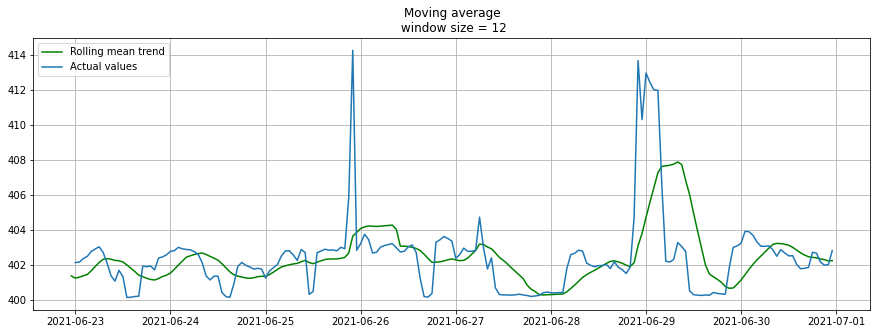

In [137]:
plotMovingAverage(grouped_df_mean['co2'], 12)

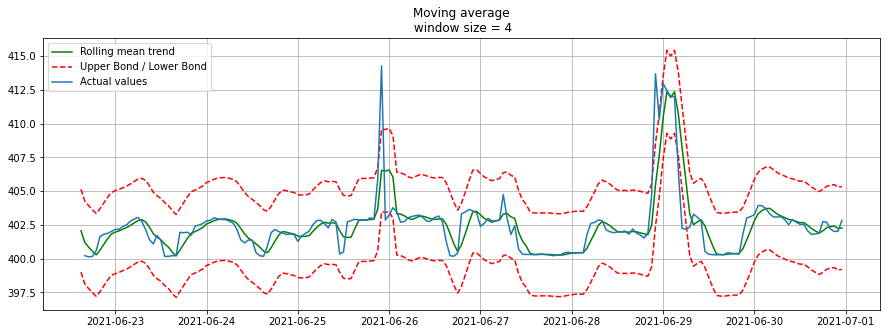

In [138]:
plotMovingAverage(grouped_df_mean['co2'], 4, plot_intervals=True)

In [139]:
grouped_df_mean_co2 = grouped_df_mean.loc[:,['co2']]
co2_anomaly = grouped_df_mean_co2.copy()
co2_anomaly.iloc[-20] = co2_anomaly.iloc[-20] * 0.2 # say we have 80% drop of co2

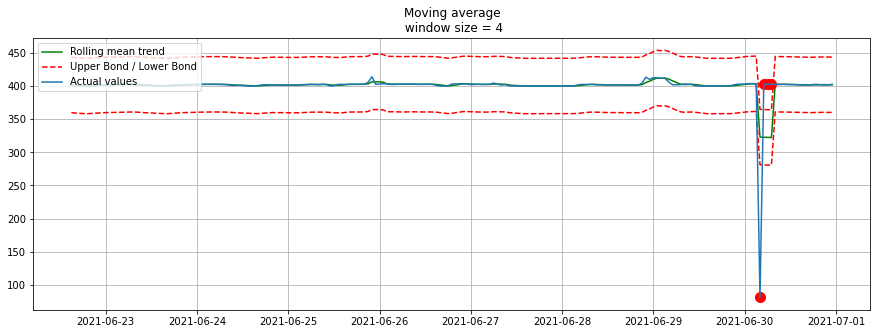

In [140]:
plotMovingAverage(co2_anomaly, 4, plot_intervals=True, plot_anomalies=True)